# Classification

Survival prediction of patients with heart failure.

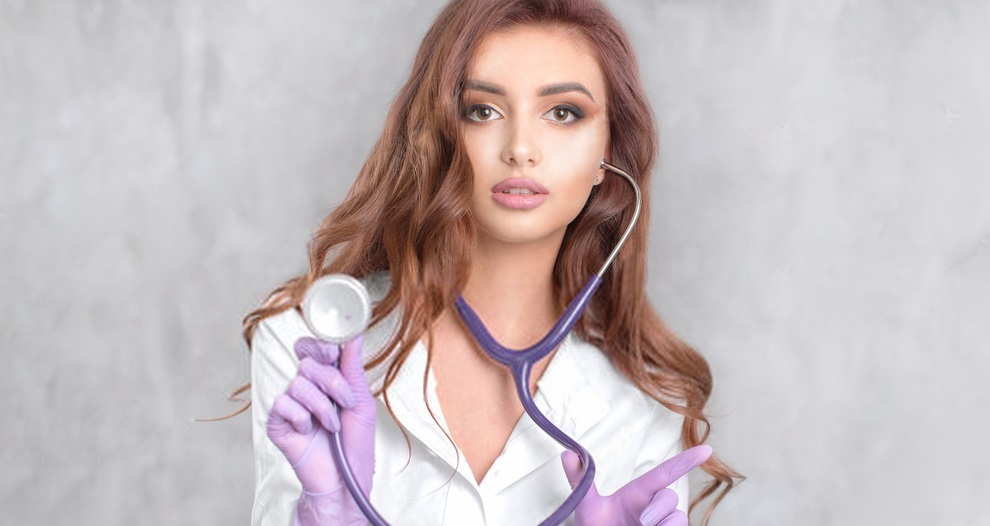

`Data Source: ` [Heart Failure](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) 

In this project, we will use a [dataset from Kaggle](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) to predict the survival of patients with heart failure from serum creatinine and ejection fraction, and other factors such as age, anemia, diabetes, and so on.

`About The Dataset:`

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

`Data Dictionary:`

1. Feature details

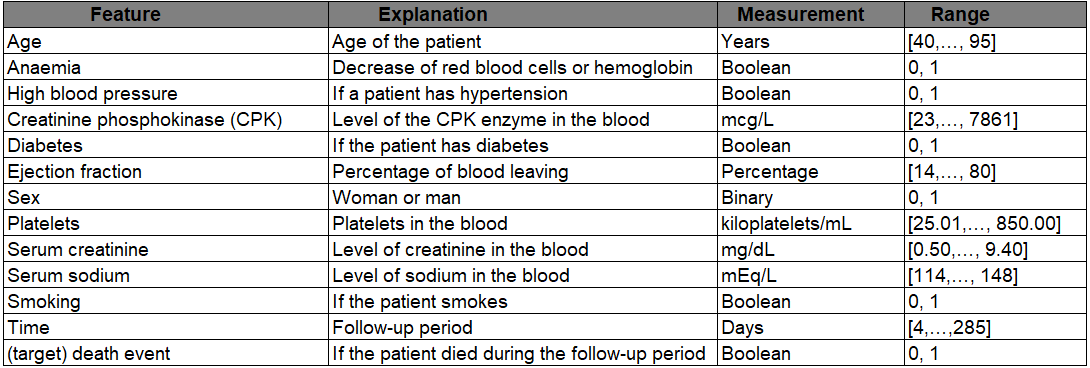

2. Boolean features
   - Sex - 0 = Female, Male = 1
   - Diabetes - 0 = No, 1 = Yes
   - Anaemia - 0 = No, 1 = Yes
   - High_blood_pressure - 0 = No, 1 = Yes
   - Smoking - 0 = No, 1 = Yes
   - DEATH_EVENT - 0 = No, 1 = Yes

3. Other informations
      - mcg/L: micrograms per liter.                  
      - mL: microliter. 
      - mEq/L: milliequivalents per litre
      - The time feature seams to be highly correlated to the death event but there is no concret information of how this               metric was measured patient by patient. Which makes it hard to use it in the analysis.

***

### Load Libraries and Data Inspection

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('heart_failure.csv')
print(df.shape)
df.head()

(299, 15)


,Unnamed: 0,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,death_event
0,0,75.0,no,582,no,20,yes,265000.00,1.9,130,yes,no,4,1,yes
1,1,55.0,no,7861,no,38,no,263358.03,1.1,136,yes,no,6,1,yes
2,2,65.0,no,146,no,20,no,162000.00,1.3,129,yes,yes,7,1,yes
3,3,50.0,yes,111,no,20,no,210000.00,1.9,137,yes,no,7,1,yes
4,4,65.0,yes,160,yes,20,no,327000.00,2.7,116,no,no,8,1,yes


In this dataset, we will use column `death_event` as our class label.

### Class Distribution (death_event) 

Only 32% of our samples failed to survive given of heart failure.

In [3]:
print(df['death_event'].value_counts())
# proportion
df['death_event'].value_counts() / len(df)

no     203
yes     96
Name: death_event, dtype: int64


no     0.67893
yes    0.32107
Name: death_event, dtype: float64

`We have a very small and slightly imbalance dataset`. We can't confidently use accuracy as our scoring method.

`note:` For unbalance dataset we must use recall, precision and f1 for scoring.

`recall:` number of correct prediction out of total Actual Positive. usecase if we need to reduce the False Negative like in cancer detection, we dont want our model to predict a person to be negative while the truth is positive.

`precision:` number of positive in Actual out total Positive prediction. i.e in cases we need to reduce the False Positives like in spam detection, we dont want to predict an important mail to be a spam.

### General Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                299 non-null    int64  
 1   age                       299 non-null    float64
 2   anaemia                   299 non-null    object 
 3   creatinine_phosphokinase  299 non-null    int64  
 4   diabetes                  299 non-null    object 
 5   ejection_fraction         299 non-null    int64  
 6   high_blood_pressure       299 non-null    object 
 7   platelets                 299 non-null    float64
 8   serum_creatinine          299 non-null    float64
 9   serum_sodium              299 non-null    int64  
 10  sex                       299 non-null    object 
 11  smoking                   299 non-null    object 
 12  time                      299 non-null    int64  
 13  DEATH_EVENT               299 non-null    int64  
 14  death_even

Anaemia, diabets, high_blood_pressure, sex, and smoking are in 'str' datatype. In TensorFlow with Keras, we needs to convert all the categorical features and labels into one-hot encoding vectors. 

### Define X and y
Lets define first our class and features. One advantage of Neural Network to traditional Machine Learning algorithm is that we don't need to do a feature selection, Neural Network learn from it's data and adjust features weight accordingly.

In [5]:
y = df['death_event']
X = df.loc[:,'age':'time']
X.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,no,582,no,20,yes,265000.00,1.9,130,yes,no,4
1,55.0,no,7861,no,38,no,263358.03,1.1,136,yes,no,6
2,65.0,no,146,no,20,no,162000.00,1.3,129,yes,yes,7


### One-Hot Encoding
One hot encode our X features. Convert categorical features (anaemia, diabets, high_blood_pressure, sex, and smoking are) to one-hot encoding vectors and assign the result back to variable X.

In [6]:
X = pd.get_dummies(X)
X.head(3)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia_no,anaemia_yes,diabetes_no,diabetes_yes,high_blood_pressure_no,high_blood_pressure_yes,sex_no,sex_yes,smoking_no,smoking_yes
0,75.0,582,20,265000.00,1.9,130,4,1,0,1,0,0,1,0,1,1,0
1,55.0,7861,38,263358.03,1.1,136,6,1,0,1,0,1,0,0,1,1,0
2,65.0,146,20,162000.00,1.3,129,7,1,0,1,0,1,0,0,1,0,1


### Split data
Splitting our train and test data to 70:30 ratio.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 7
                                                   )

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(209, 17) (90, 17) (209,) (90,)


### Standardized 
Standardized our features.

In [8]:
ct = ColumnTransformer([("numeric", StandardScaler(), 
                        x_train.columns 
                        )])
print(ct)
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time', 'anaemia_no', 'anaemia_yes',
       'diabetes_no', 'diabetes_yes', 'high_blood_pressure_no',
       'high_blood_pressure_yes', 'sex_no', 'sex_yes', 'smoking_no',
       'smoking_yes'],
      dtype='object'))])


### Label Encoder 
Convert the class/label to integers ranging from 0 to the number of classes.

In [9]:
lencoder = LabelEncoder()
y_train = lencoder.fit_transform(y_train.astype(str)) 
y_test = lencoder.fit_transform(y_test.astype(str))

# Show mapping
class_mapping = {l: i for i, l in enumerate(lencoder.classes_)}
class_mapping

{'no': 0, 'yes': 1}

### Re-shape to 2d array

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Designing a Deep Learning Model For Classification

The model is optimized using the `adam` optimizer and seeks to minimize the `categorical cross-entropy` loss. Using `Recall` as our metric. We need to reduce the False Negative rate because we dont want our model to predict a person to be negative while the truth is positive.

In [11]:
model = Sequential()

# input layer
model.add(InputLayer(input_shape=(x_train.shape[1],)))

# hidden layer1
model.add(Dense(12, activation='relu'))

# output layer
# supposedly we have to use 'sigmoid' and 'binary_crossentrophy' here 
# but I will try using softmax and input two neurons(we have two classes).
model.add(Dense(2, activation='softmax')) 

# compile
# I want to monitor the recall score for this instance
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Recall'])


# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

### Early Stopping

In [12]:
# reference https://keras.io/api/callbacks/early_stopping/
stop = EarlyStopping(monitor='val_loss',
                     patience=20,
                     verbose=1)

### Training Phase

In [13]:
# # fix random seed for reproducibility
tf.random.set_seed(7)


h = model.fit(x_train, y_train, 
               validation_data= (x_test, y_test), 
               epochs=300, 
               batch_size= 64,
               verbose=1,
               callbacks=[stop]
             )



Epoch 1/300
4/4 [==============================] - 1s 80ms/step - loss: 0.8256 - recall: 0.4928 - val_loss: 0.7558 - val_recall: 0.5889
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.8039 - recall: 0.5215 - val_loss: 0.7346 - val_recall: 0.6111
Epoch 3/300
4/4 [==============================] - 0s 11ms/step - loss: 0.7832 - recall: 0.5167 - val_loss: 0.7159 - val_recall: 0.6222
Epoch 4/300
4/4 [==============================] - 0s 10ms/step - loss: 0.7652 - recall: 0.5455 - val_loss: 0.6980 - val_recall: 0.6444
Epoch 5/300
4/4 [==============================] - 0s 10ms/step - loss: 0.7470 - recall: 0.5694 - val_loss: 0.6812 - val_recall: 0.6556
Epoch 6/300
4/4 [==============================] - 0s 11ms/step - loss: 0.7315 - recall: 0.5885 - val_loss: 0.6660 - val_recall: 0.6778
Epoch 7/300
4/4 [==============================] - 0s 11ms/step - loss: 0.7164 - recall: 0.5981 - val_loss: 0.6518 - val_recall: 0.6889
Epoch 8/300
4/4 [==============================]

Epoch 61/300
4/4 [==============================] - 0s 10ms/step - loss: 0.4544 - recall: 0.7943 - val_loss: 0.3806 - val_recall: 0.8556
Epoch 62/300
4/4 [==============================] - 0s 10ms/step - loss: 0.4522 - recall: 0.7990 - val_loss: 0.3783 - val_recall: 0.8556
Epoch 63/300
4/4 [==============================] - 0s 10ms/step - loss: 0.4499 - recall: 0.8038 - val_loss: 0.3761 - val_recall: 0.8556
Epoch 64/300
4/4 [==============================] - 0s 10ms/step - loss: 0.4479 - recall: 0.7943 - val_loss: 0.3737 - val_recall: 0.8667
Epoch 65/300
4/4 [==============================] - 0s 10ms/step - loss: 0.4458 - recall: 0.7943 - val_loss: 0.3715 - val_recall: 0.8778
Epoch 66/300
4/4 [==============================] - 0s 10ms/step - loss: 0.4441 - recall: 0.7943 - val_loss: 0.3692 - val_recall: 0.8778
Epoch 67/300
4/4 [==============================] - 0s 9ms/step - loss: 0.4420 - recall: 0.7943 - val_loss: 0.3672 - val_recall: 0.8778
Epoch 68/300
4/4 [========================

Epoch 121/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3745 - recall: 0.8373 - val_loss: 0.3109 - val_recall: 0.9000
Epoch 122/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3735 - recall: 0.8421 - val_loss: 0.3105 - val_recall: 0.9000
Epoch 123/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3728 - recall: 0.8421 - val_loss: 0.3101 - val_recall: 0.9000
Epoch 124/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3720 - recall: 0.8421 - val_loss: 0.3098 - val_recall: 0.9000
Epoch 125/300
4/4 [==============================] - 0s 11ms/step - loss: 0.3711 - recall: 0.8373 - val_loss: 0.3096 - val_recall: 0.9000
Epoch 126/300
4/4 [==============================] - 0s 15ms/step - loss: 0.3705 - recall: 0.8421 - val_loss: 0.3093 - val_recall: 0.9000
Epoch 127/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3698 - recall: 0.8421 - val_loss: 0.3085 - val_recall: 0.9000
Epoch 128/300
4/4 [===============

`Note:` We will get slightly different results if we re-run the training phase multiple times due to algorithm nature (callbacks and validation data).

Consider running the training phase a few times and compare the average outcome.

In [14]:
h.history.keys()

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


### Plotting for Recall Score

Text(0, 0.5, 'Recall')

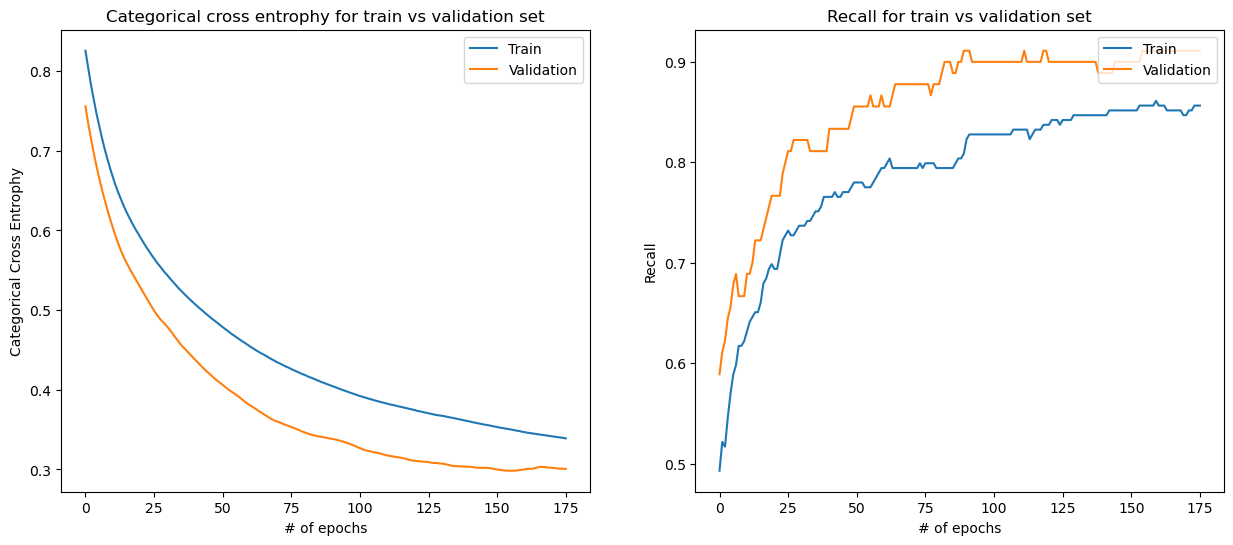

In [15]:
#plotting for Recall

fig, axs = plt.subplots(1,2,
                        figsize=(15, 6),
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.2}) 
(ax1, ax2) = axs
# Binary Entrophy
ax1.plot(h.history['loss'], label='Train')
ax1.plot(h.history['val_loss'], label='Validation')
ax1.set_title('Categorical cross entrophy for train vs validation set')
ax1.legend(loc="upper right")
ax1.set_xlabel("# of epochs")
ax1.set_ylabel("Categorical Cross Entrophy")

# Recall
ax2.plot(h.history['recall'], label='Train')
ax2.plot(h.history['val_recall'], label='Validation')
ax2.set_title('Recall for train vs validation set')
ax2.legend(loc="upper right")
ax2.set_xlabel("# of epochs")
ax2.set_ylabel("Recall")

### Accuracy

In [16]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss", loss, "Accuracy:", acc)

Loss 0.30071821808815 Accuracy: 0.9111111164093018


### Evaluation

In [17]:
y_pred = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1], dtype=int64)

In [18]:
y_true = np.argmax(y_test, axis=1)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        65
           1       0.90      0.76      0.83        25

    accuracy                           0.91        90
   macro avg       0.91      0.86      0.88        90
weighted avg       0.91      0.91      0.91        90



In [20]:
model_matrix = confusion_matrix(y_true, y_pred)
model_matrix

array([[63,  2],
       [ 6, 19]], dtype=int64)

<AxesSubplot:>

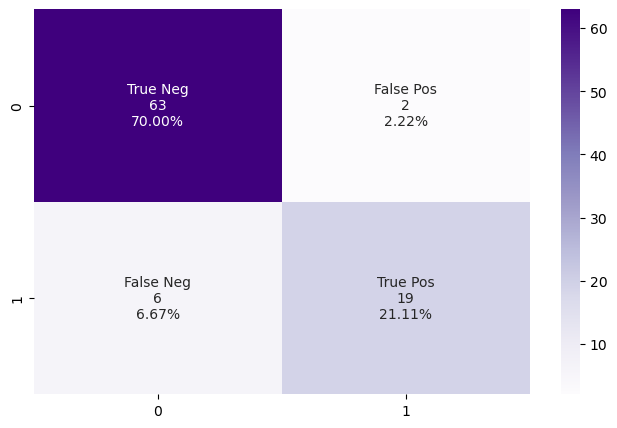

In [21]:
# Visualize
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

In [22]:
Recall2    = recall_score(y_true, y_pred)
Recall2

0.76

After playing with different hyperparameters combination value, we were able to produce a model thats not overfit nor underfit and at the same time we minimize the recall score.

Let's try using GridSearchCV if we can reproduce the same hyperpameter and recall score.

# Hyperpameter Tunning
We will use GridSearchCV to find the optimal hyperparameter value, however using this method is very CPU computational expensive (there's a technique that can improve training/gridsearch speed but we will not do it here). We will do  search each hyperameter individually with minimum search value.

### Data Preparation for GridSearchCV

In [23]:
df = pd.read_csv('heart_failure.csv')
y = df['death_event']
X = df.loc[:,'age':'time']
#
X  = pd.get_dummies(X)
#
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
#
ct = ColumnTransformer([("numeric", StandardScaler(), 
                        X_train.columns 
                        )])
#
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
#
le= LabelEncoder()
Y_train = le.fit_transform(Y_train.astype(str))
Y_test = le.transform(Y_test.astype(str))

### Batch_size and Epoch

Batch size define how many patterns to read at a time and keep in memory. The number of epochs is the number of times the entire training dataset is shown to the network during training

In [24]:
# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    
    model.add(InputLayer(input_shape=(X_train.shape[1])))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)

Note: We will do small search for epoches and batch sizes here. Unfotunately my computer can't handle the computational power of searching with big data.

But I did gridsearch this in google collab. Here's the link for reference:

[My_GoogleCollab](https://colab.research.google.com/drive/170UZJqz5uGmfGnPdLCI9qrkdvVrD-0Fy#scrollTo=UXUFvSQmY-A-)


In [25]:
# define the grid search parameters

# See in google collab
# batch_size = [X_train.shape[1], 64, 100]
# epochs = [50, 80, 100]
# cv = 3

batch_size = [x_train.shape[1], 64]
epochs = [50, 80]

param_grid = dict(
                  batch_size = batch_size,
                  epochs = epochs
                  )

In [26]:
grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid,
                    n_jobs=-1,
                    verbose=1, 
                    cv=2)


grid_result = grid.fit(X_train, Y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [27]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.794277 using {'batch_size': 17, 'epochs': 50}
0.794277 (0.003800) with: {'batch_size': 17, 'epochs': 50}
0.775092 (0.005861) with: {'batch_size': 17, 'epochs': 80}
0.741621 (0.001236) with: {'batch_size': 64, 'epochs': 50}
0.770284 (0.010668) with: {'batch_size': 64, 'epochs': 80}


### Number of Neurons in the Hidden Layer
The number of neurons in a layer is an important parameter to tune. Generally the number of neurons in a layer controls the representational capacity of the network, at least at that point in the topology.

Also, generally, a large enough single layer network can approximate any other neural network, at least in theory.


In [28]:
# Function for number of neurons in hidden layer 1
def create_model_neurons(neurons):
    model = Sequential()
    
    model.add(InputLayer(input_shape=(X_train.shape[1])))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [29]:
# create model
model = KerasClassifier(model = create_model_neurons,
                          epochs = 80,
                          batch_size = 17,
                          verbose=0)

In [30]:
# define the grid search parameters
neurons = [1, 5, 10, 15, 20]

param_grid = dict(
                  model__neurons = neurons
                  )

In [31]:
grid = GridSearchCV(estimator=model, 
                    param_grid = param_grid, 
                    n_jobs=-1, 
                    cv=2)

grid_result = grid.fit(X_train, Y_train)

In [32]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.798993 using {'model__neurons': 15}
0.674634 (0.001557) with: {'model__neurons': 1}
0.727518 (0.051328) with: {'model__neurons': 5}
0.789377 (0.020147) with: {'model__neurons': 10}
0.798993 (0.010531) with: {'model__neurons': 15}
0.789515 (0.008562) with: {'model__neurons': 20}


### Dropout Regularization
Limit overfitting and improve the model’s ability to generalize. For the best results, dropout is best combined with a weight constraint such as the max norm constraint.



In [33]:
# Function for dropout value in hidden layer 1
def create_model_dropout(dropout_rate, weight_constraint):
    model = Sequential()
    
    # input layer
    model.add(InputLayer(input_shape=(X_train.shape[1])))
    
    # hidden layer1
    model.add(Dense(15, activation ='relu', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    
    #output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [34]:
# create model
model = KerasClassifier(model = create_model_dropout,
                          epochs = 80,
                          batch_size = 17,
                          verbose=0)

In [35]:
# define the grid search parameters
# weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

weight_constraint = [1.0, 2.0]
dropout_rate = [0.0, 0.1, 0.2]

param_grid = dict(
                  model__dropout_rate = dropout_rate,
                  model__weight_constraint = weight_constraint
                 )


In [36]:
grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid, 
                    n_jobs = -1, 
                    cv=2)

grid_result = grid.fit(X_train, Y_train)

In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.808654 using {'model__dropout_rate': 0.2, 'model__weight_constraint': 2.0}
0.755907 (0.015522) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.755998 (0.003617) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.780082 (0.037225) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.789560 (0.018132) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.794185 (0.015339) with: {'model__dropout_rate': 0.2, 'model__weight_constraint': 1.0}
0.808654 (0.008654) with: {'model__dropout_rate': 0.2, 'model__weight_constraint': 2.0}


### Neuron Activation Function
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

--WIP--

### Learning Rate and Momentum
--WIP--

To be continue...